## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## STEP1:Compute the camera calibration using chessboard images

### 1.0 Dependenies

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Load images
Load the images for camera calibration.

In [2]:
pat_camera_cal = 'camera_cal/'
name_images = os.listdir(pat_camera_cal)
fullPath_images = ['{0}{1}'.format(pat_camera_cal, name_image) for name_image in name_images]

In [3]:
len(fullPath_images)

20

### 1.2 Compute camera calibration

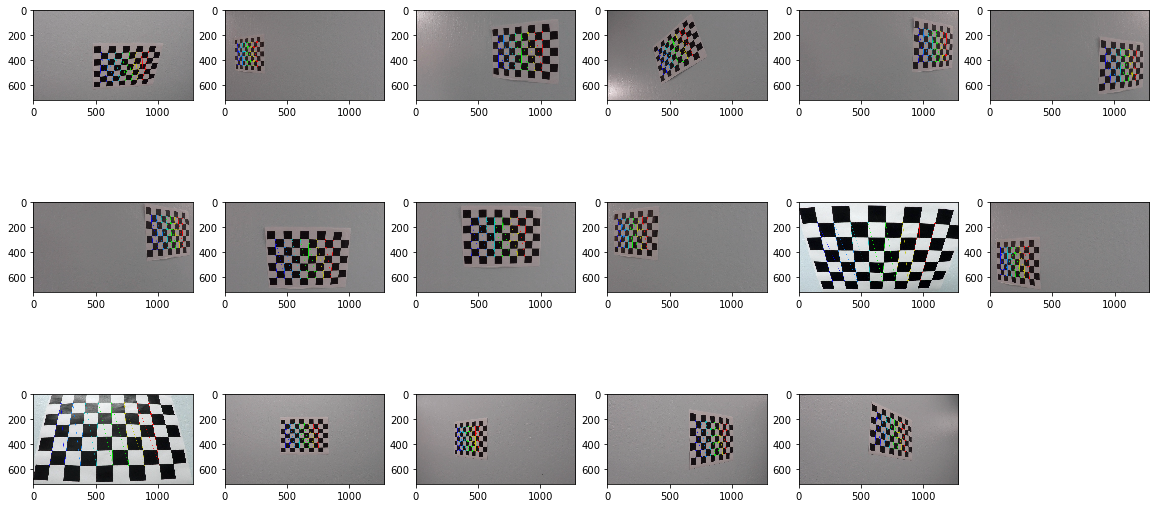

In [4]:
nx = 6
ny = 9

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
chessFound_imgs = [] # Images that are found chess boards


# Step through the list and search for chessboard corners
for index, fullpath_image in enumerate(fullPath_images):
    
    img = cv2.imread(fullpath_image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        chessFound_imgs.append(img)

      
f, axs = plt.subplots(3, 6, figsize=(20, 10))
axs[-1][-1].remove() # There were 18 cells but only 17 cells are needed, remove the last one.

for index, image in enumerate(chessFound_imgs):
    idx_row = index // 6
    inx_col = index % 6
    axs[idx_row][inx_col].imshow(image)

### 1.2.5 Camera calibration

In [5]:
# Do camera calibration given object points and image points       
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (1280, 720), None, None)

### 1.3 Test undistortion on an image
Let's see how camera calibration works on chessboard image, would it correct the camera distortion ?

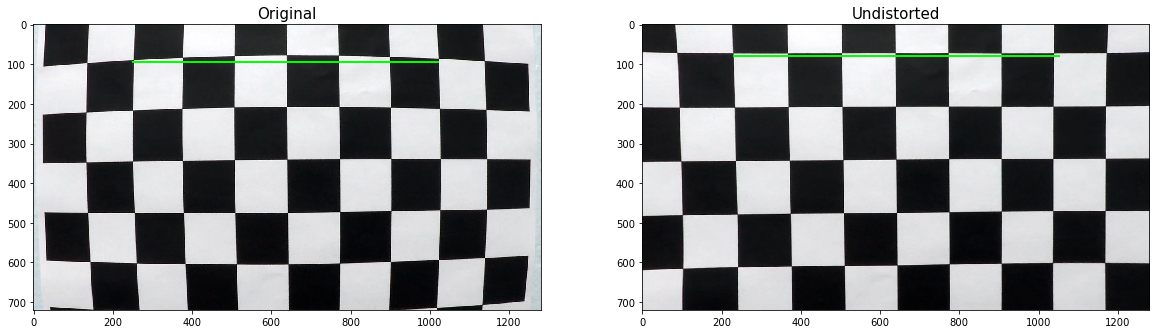

In [6]:
img = cv2.imread(fullPath_images[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
cv2.line(img, (250, 95), (1020, 95), (0, 255, 0), 3) # Draw a straight line to see the effects of camera distrotion
ax1.imshow(img)
ax1.set_title('Original', fontsize=15)

cv2.line(dst, (230, 80), (1050, 80), (0, 255, 0), 3) # Draw a straight line to see how the camera calibration worked out
ax2.imshow(dst)
ax2.set_title('Undistorted', fontsize=15)

## Step2: Laneline extraction & bird view

### Helper functions
Helper functions to apply filters on images.

In [78]:
def mask_image(image):
    imshape = image.shape
     # Masked area
    left_bottom = (150, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    mask = np.zeros_like(image)  
    
    mask = cv2.fillPoly(mask, vertices, (255, 255, 255))
    masked_image = cv2.bitwise_and(image, mask)
    
    return masked_image

def BGR2HLS(image, channel = None, lowbound = 90, highbound = 255):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    channels = {
                 'h' : hls[:,:,0],
                 'l' : hls[:,:,1],
                 's' : hls[:,:,2],
               }
    
    if channel != None:
        target_channel = channels.get(channel)
        assert target_channel != None, 'By selecting the target channel, please type in "h" or "l" or "s".'
        binary_output = np.zeros_like(target_channel)
        binary_output[(target_channel > lowbound) & (target_channel <= highbound)] = 1
        return binary_output
    else:
        return channels['h'], channels['l'], channels['s']
    
def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.5)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1,  ksize = sobel_kernel)
    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    g_dir = np.arctan2(sobely_abs, sobelx_abs)
    binary_output = np.zeros_like(g_dir)
    binary_output[(g_dir >= thresh[0]) & (g_dir <= thresh[1])] = 1
    return binary_output

def magnitude_threshold(image, size_kernel = 3, threshold = (80, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = size_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = size_kernel)
    sobel_abs = np.sqrt(sobel_x**2 + sobel_y**2)
    binary_output = np.zeros_like(sobel_abs)
    binary_output[(sobel_abs <= threshold[1]) & (sobel_abs >= threshold[0])] = 1
    return binary_output

def sobel_threshold(image, direct = 'x', size_kernel = 3, threshold = (80, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if direct =='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = size_kernel)
    if direct =='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = size_kernel)
    sobel = np.absolute(sobel)
    sobel_rescaled = np.uint8(sobel/np.max(sobel)*255)    
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel <= threshold[1]) & (sobel >= threshold[0])] = 1
    return binary_output

def filters_combination(image):
    hls = BGR2HLS(image,channel='s')
    direction = dir_threshold(image)
    mag = magnitude_threshold(image)
    sobel_x = sobel_threshold(image)
    sobel_y = sobel_threshold(image, direct = 'y')
    output = np.zeros_like(hls)
#     output[((hls == 1) & (direction == 1) | (mag == 1) | (sobel_x == 1) | (sobel_y == 1))] = 255
    output[((hls == 1) | (sobel_x == 1))] = 255

    return output


def BGR2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## 2.1 Filters visualization
By seeing the filters, we can find what filters suit our need.

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  # This is added back by InteractiveShellApp.init_path()


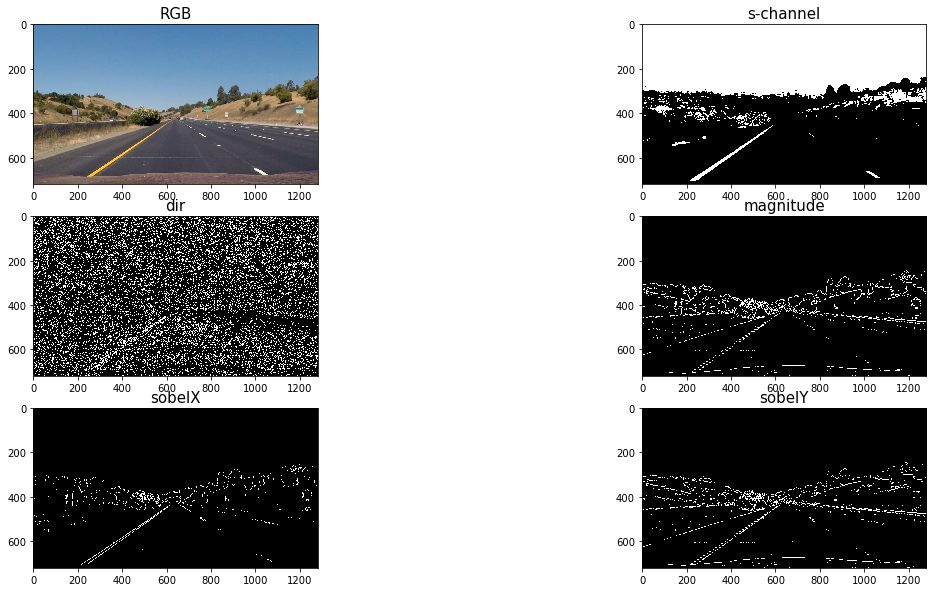

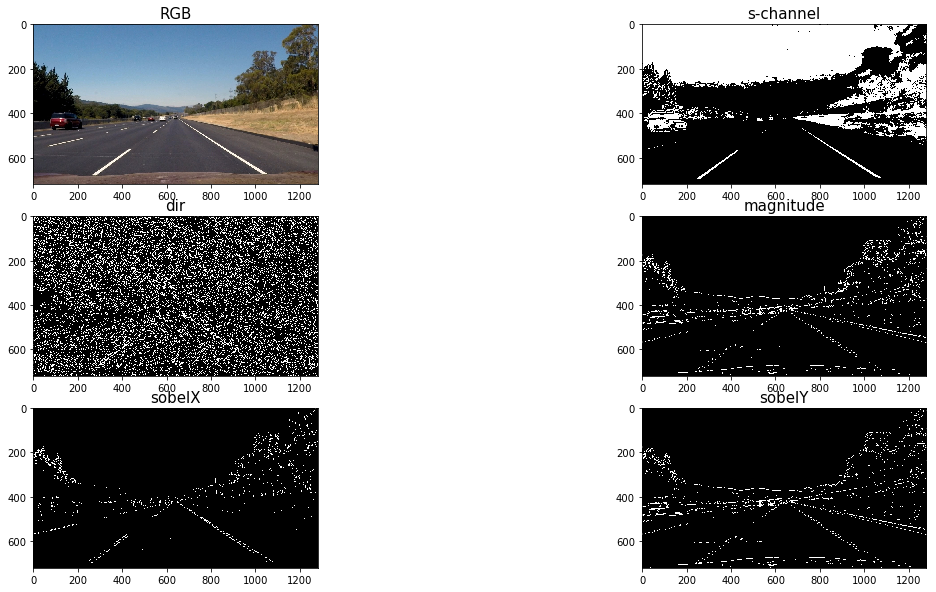

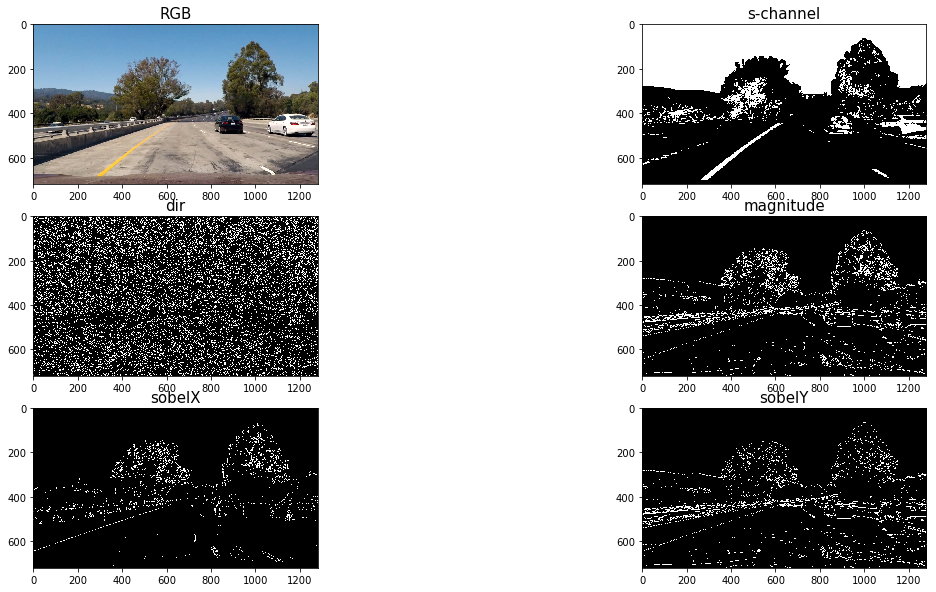

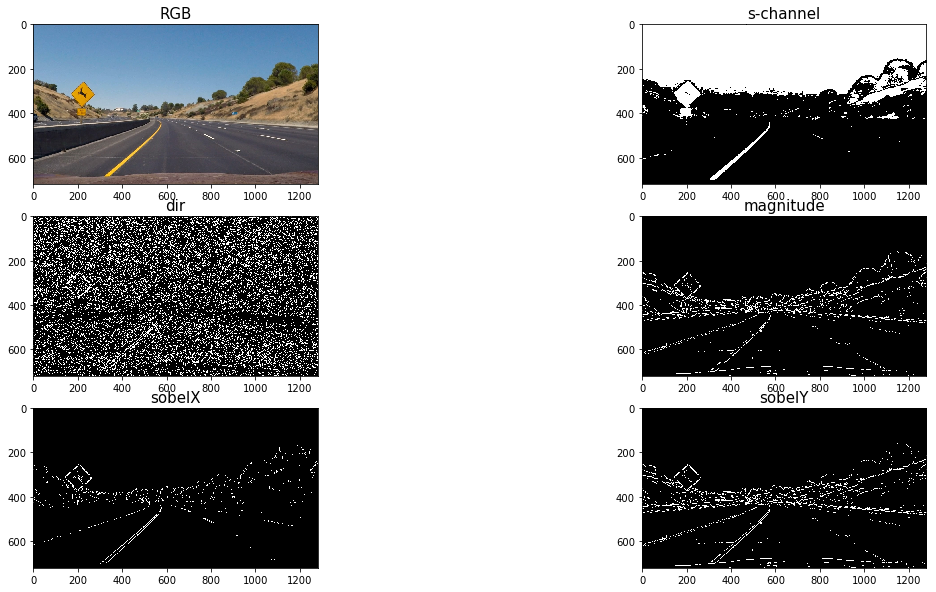

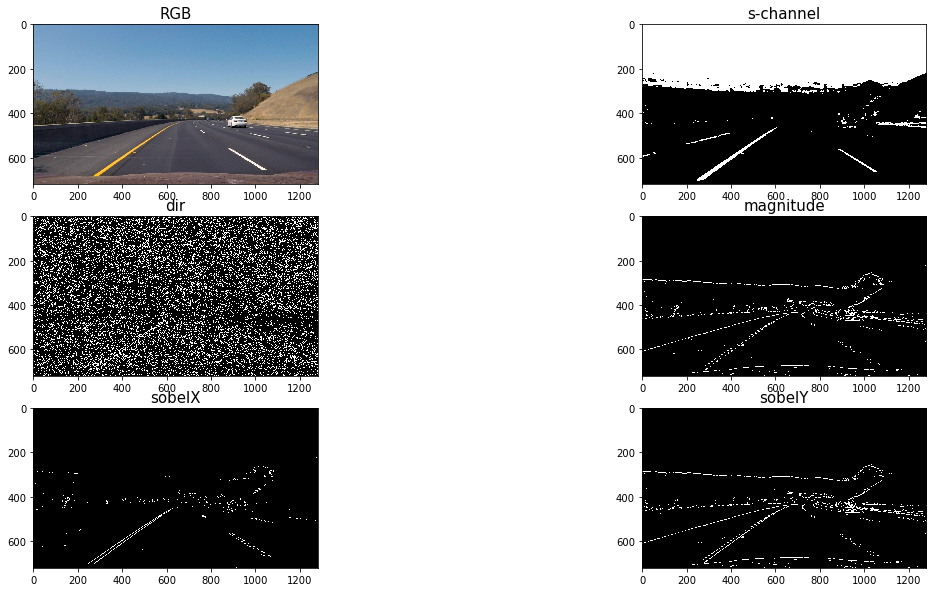

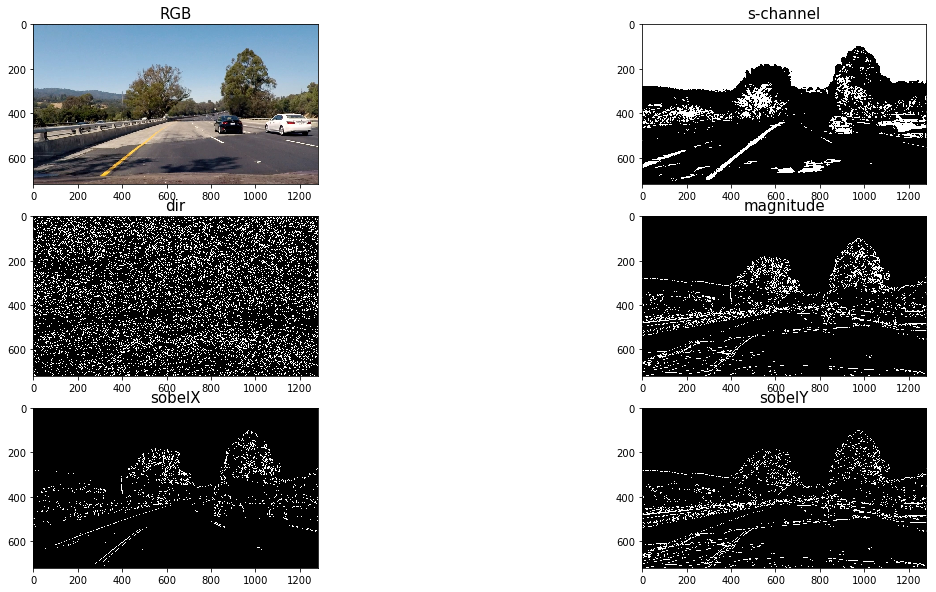

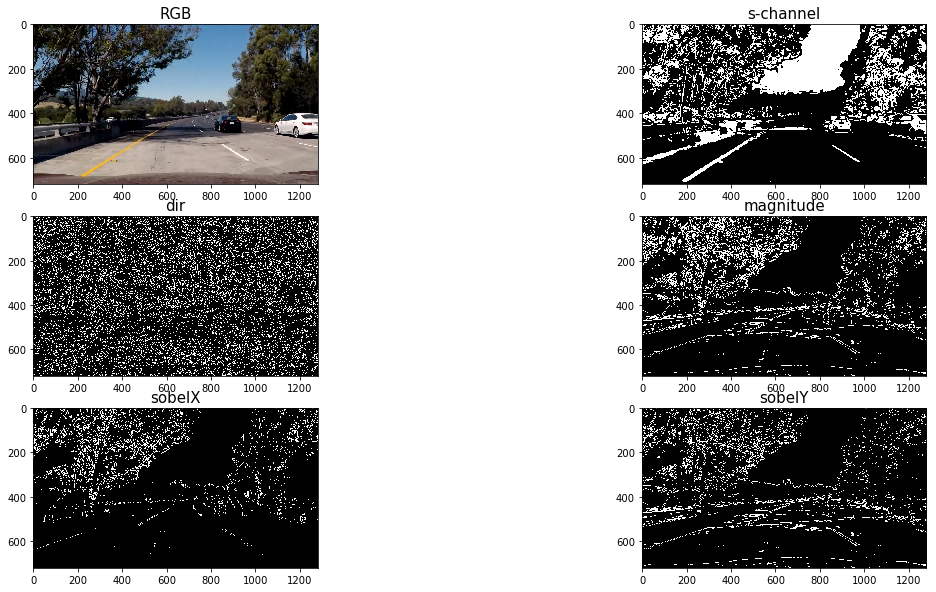

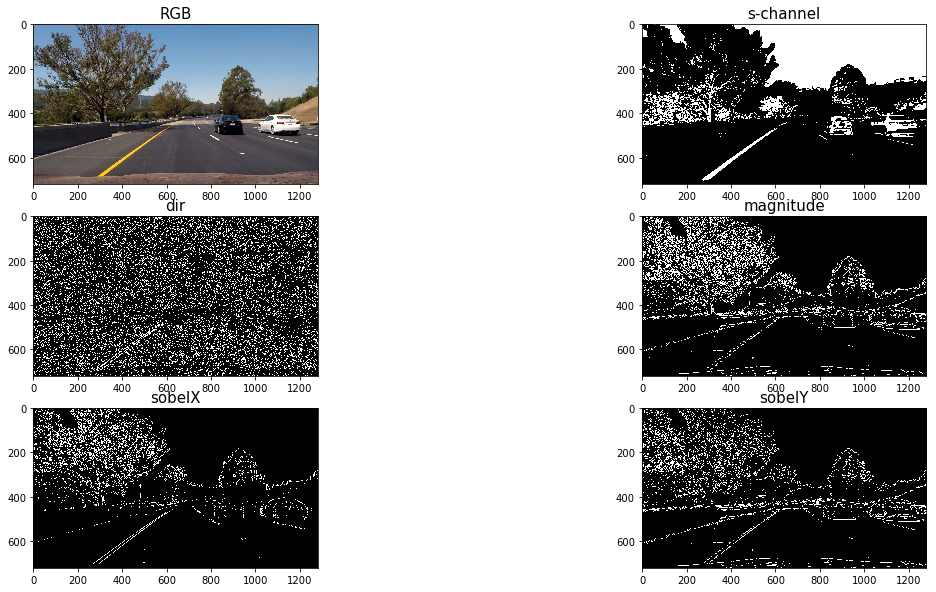

In [9]:
import os

## Load test images
path = 'test_images/'
name_testImgs = os.listdir(path)
name_testImgs = ['{0}{1}'.format(path, image) for image in name_testImgs]

## Loop through the whole images and apply filters on them
for name_testImg in name_testImgs:

    img = cv2.imread(name_testImg)
    rgb_img = BGR2RGB(img)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax0, ax1, ax2) = plt.subplots(3, 2, figsize=(20,10))
    
    # raw image
    ax0[0].imshow(rgb_img)
    ax0[0].set_title('RGB', fontsize=15)
    
    # s channel
    ax0[1].imshow(BGR2HLS(dst, channel='s'), cmap='gray')
    ax0[1].set_title('s-channel', fontsize=15)
    
    # direction
    ax1[0].imshow(dir_threshold(dst), cmap='gray')
    ax1[0].set_title('dir', fontsize=15)

    # magnitude
    ax1[1].imshow(magnitude_threshold(dst), cmap='gray')
    ax1[1].set_title('magnitude', fontsize=15)

    # sobelX
    ax2[0].imshow(sobel_threshold(dst), cmap='gray')
    ax2[0].set_title('sobelX', fontsize=15)

    # sobel Y
    ax2[1].imshow(sobel_threshold(dst, direct='y'), cmap='gray')
    ax2[1].set_title('sobelY', fontsize=15)

## Pipeline
<br/>
<li>Undistirt image</li>
<li>Bird eye</li>
<li>Lane searching</li>
<li>Fits line to polynimial</li>
<li>Perspective transform</li>

In [205]:
def perspective_transform(image, src, dst):
    image_size = image.shape[:2][::-1]
    src = np.float32(src)
    dst = np.float32(dst)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, image_size)
    return warped

def undistortion(image):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

def histogram(binary_image):
    return np.sum(image, axis = 0)

def pipeline(image, n_windows = 9):
    height_img = image.shape[0]
    width_img = image.shape[1]
    
    # Preprocess the image.
    udst = undistortion(image)
    fitered = filters_combination(udst)
    masked = mask_image(fitered)
    
    src = [[300, 700], [1080, 700], [800, 500], [500, 500]] 
    dst = [[300, 700], [900, 700], [1000, 0], [200, 0]]
    binary_warped = perspective_transform(masked, src, dst)
    
    ## Laneline searching
    ## 1.Split the input image into two
    ## 2.Use histogram to find out where the lane lines would be
    ## 3.Slide window
    
    his = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    mid_point = his.shape[0] // 2
    his_left = his[:mid_point]
    his_right = his[mid_point:]
    
    leftX_current = np.argmax(his_left)
    rightX_current = np.argmax(his_right) + mid_point
    nonzero_pixels = binary_warped.nonzero()
    nonzerox = np.array(nonzero_pixels[1])
    nonzeroy = np.array(nonzero_pixels[0])
    
    size_window = height_img // n_windows
    margin = 100
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []
    output = np.dstack((binary_warped, binary_warped, binary_warped))
    
    for i in range(n_windows):
        win_y_low = height_img - ((i + 1) * size_window)
        win_y_high = height_img - (i * size_window)
        win_xleft_low = leftX_current - margin
        win_xleft_high = leftX_current + margin
        win_xright_low = rightX_current - margin
        win_xright_high = rightX_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    output[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255,0,0]
    output[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,0,255]
    
    leftfitX = nonzerox[left_lane_inds]
    leftfixY = nonzeroy[left_lane_inds]
    rightfitX = nonzerox[right_lane_inds]
    rightfixY = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(leftfixY, leftfitX, 2)
    right_fit = np.polyfit(rightfixY, rightfitX, 2)
    
    ploty = np.linspace(0, 719, 720)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fit = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    left_line_pts = np.hstack((left_line_window1, right_line_window2))    
    output = cv2.fillPoly(output, np.int_([left_line_pts]), (0,255, 0))
    
    clone_src_img = image.copy()
    output_warped = perspective_transform(output, dst, src)
    result = cv2.addWeighted(clone_src_img, 1, output_warped, 0.5, 0)
    return image, masked, binary_warped, output_warped, result

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


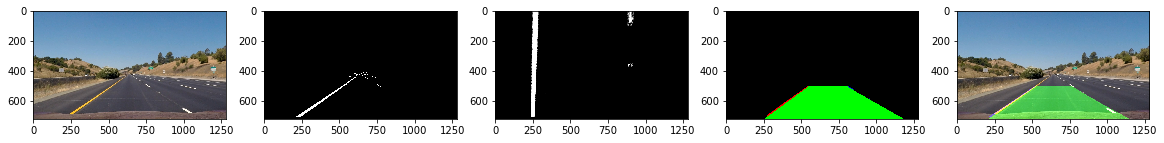

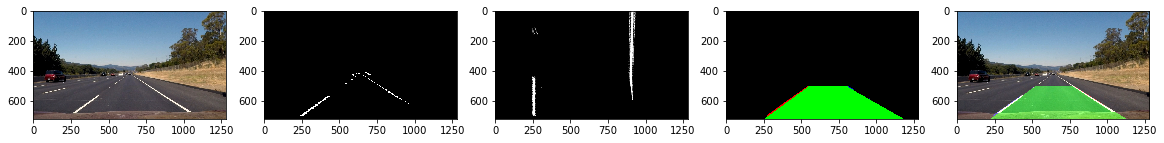

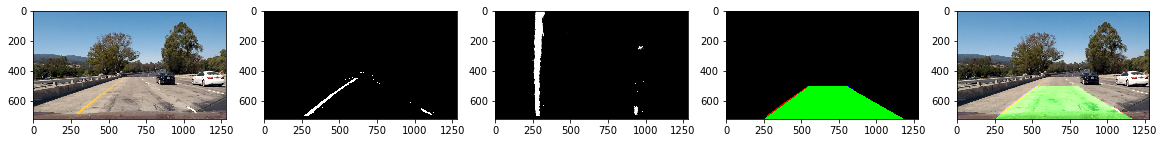

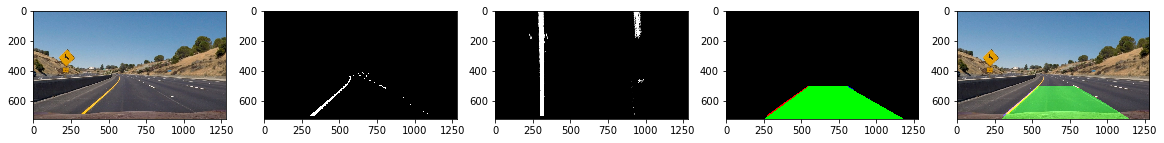

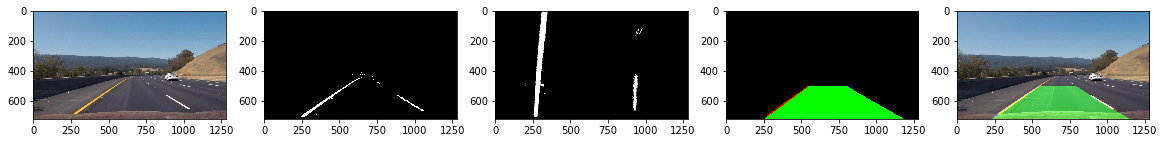

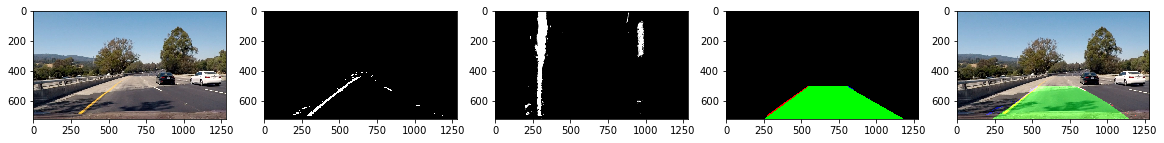

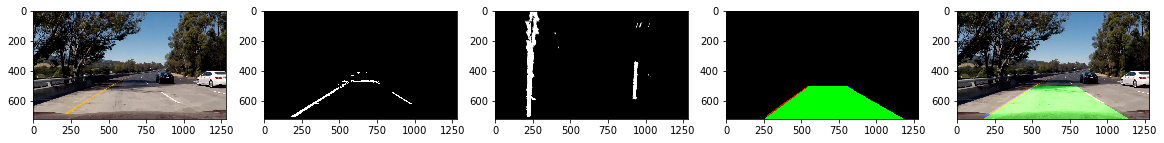

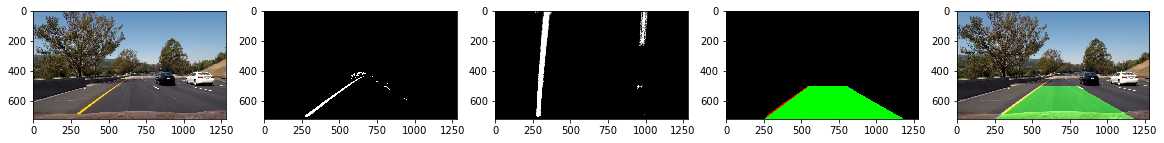

In [208]:
import os

root = 'test_images/'
imgs = os.listdir(root)
imgs = ['{0}{1}'.format(root, img_name) for img_name in imgs]
plt.figure(figsize=(10, 5))
for img in imgs:
    f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20,10))
    img = cv2.imread(img)
    image, masked, binary_warped, output_warped, result = pipeline(img)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    ax0.imshow(img)
    ax1.imshow(masked, cmap='gray')
    
    ax2.imshow(binary_warped, cmap='gray')
    ax3.imshow(out)
    
    ax4.imshow(result)
#     plt.show()